In [1]:
# Intorduction:
#   This repository contains a Python-based simulation framework for evaluating the effects of coefficient and output quantization on IIR filters. 
#   It compares floating-point and fixed-point implementations, providing insights into quantization-induced errors through both theoretical analysis and empirical simulation.
# Author:
#   Siqi Hui
# Version history:
#   1.0.0: initial version with basic functionality, including: 
#     - IIR filter design and implementation
#     - quantization of filter coefficients and outputs
#     - simulation of quantization errors
#   1.0.1: added support for highpass filters
#   1.0.2: added noise level parameter to simulate real-world conditions    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal


In [3]:
# quant iir
class QuantizedIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2, iir_coeff_bit, output_dec_bits=1, feedback_half_lsb=False):
        # 系数量化
        coeff_quant_factor = 1/(2**iir_coeff_bit)
        self.b0 = np.round(b0 / coeff_quant_factor) * coeff_quant_factor
        self.b1 = np.round(b1 / coeff_quant_factor) * coeff_quant_factor
        self.b2 = np.round(b2 / coeff_quant_factor) * coeff_quant_factor
        self.a1 = np.round(a1 / coeff_quant_factor) * coeff_quant_factor
        self.a2 = np.round(a2 / coeff_quant_factor) * coeff_quant_factor
        self.feedback_half_lsb = feedback_half_lsb

        # floor is just for debug, not used in real quantization
        # self.b0 = np.floor(b0 / coeff_quant_factor) * coeff_quant_factor
        # self.b1 = np.floor(b1 / coeff_quant_factor) * coeff_quant_factor
        # self.b2 = np.floor(b2 / coeff_quant_factor) * coeff_quant_factor
        # self.a1 = np.floor(a1 / coeff_quant_factor) * coeff_quant_factor
        # self.a2 = np.floor(a2 / coeff_quant_factor) * coeff_quant_factor

        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
        
        # 系数量化银子
        self.coeff_quant_factor = coeff_quant_factor
        # 输出量化因子
        self.output_dec_bits = output_dec_bits
        self.output_quant_factor = 0.5**output_dec_bits
    
    def process(self, x):
        # 计算当前输出
        y1_q = self.y1 / self.output_quant_factor
        y2_q = self.y2 / self.output_quant_factor
        a1_q = self.a1 / self.coeff_quant_factor
        a2_q = self.a2 / self.coeff_quant_factor

        # feed back: a1y1 + a2y2, # + 2**(self.output_dec_bits-1)
        # add extra offset 0.5 lsb to avoid negative feedback
        if self.feedback_half_lsb:
            feed_back_requant = np.floor((a1_q * y1_q + a2_q * y2_q + (a1_q + a2_q)/2) * self.output_quant_factor) * self.coeff_quant_factor
            # print("feed back offset: ", (a1_q/2 + a2_q/2)* self.coeff_quant_factor)
        else:
            feed_back_requant = np.floor((a1_q * y1_q + a2_q * y2_q) * self.output_quant_factor) * self.coeff_quant_factor
        y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - feed_back_requant
        y = np.floor(y / self.output_quant_factor) * self.output_quant_factor

        
        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return np.floor(y)

In [4]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [5]:
def signal_generator(fs, time, signal_range, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    return generated_signal

In [6]:
# 谐振点测试
def get_resonant_freq(fs, b0, b1, b2, a1, a2):
    """
    计算IIR滤波器的谐振频率和衰减系数。
    参数：
    fs - 采样频率
    b0, b1, b2 - IIR滤波器的分子系数
    a1, a2 - IIR滤波器的分母系数
    
    返回：
    f_res - 谐振频率(Hz)
    r_decay - 衰减系数
    Q - Q因子
    """
    a = [1, a1, a2]
    poles = np.roots(a)
    resonant_poles = [p for p in poles if np.imag(p) != 0]
    
    if not resonant_poles:
        return None, None, None
    
    pole_angle = np.angle(resonant_poles[0])   # 取一个即可（共轭角度相同）
    w_res = abs(pole_angle)
    f_res = w_res / (np.pi) * fs / 2  # 转换为频率
    r_decay = np.abs(resonant_poles[0])  # 极点的模
    Q = 1 / (2 * (1 - np.abs(resonant_poles[0])))  # Q值计算
    
    print(f"f_res: {f_res:.3f}, Q: {Q:.3f}")
    return 


In [7]:
def analyze_quantization_error(x, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=10000, signal_range=10000, noise_level=0, btype='low', feedback_half_lsb=False):
    """
    输入：
        x: 输入信号(1D numpy 数组)
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        output_dec_bits: 反馈路径的小数量化位宽
        fs: 采样率(默认10000)
        signal_range: 信号幅度缩放因子(默认10000)
        noise_level: 添加的噪声水平(默认0, 不添加噪声, 1~10的整数表示添加1~10个lsb的量化噪声)
        btype: 滤波器类型('low'表示低通滤波器, 'high'表示高通滤波器)
        feedback_half_lsb: 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈(默认False)
    功能：
        - 构建Butterworth低通滤波器
        - 执行浮点与量化滤波
        - 计算系数与反馈路径的量化误差
        - 绘图展示输出结果与误差曲线
    """
    # 设计滤波器
    fc = fc_fs_ratio * fs
    b, a = butter(2, fc / (fs / 2), btype=btype)
    
    quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, output_dec_bits, feedback_half_lsb)
    float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
    
    y_quantized = np.array([quant_iir.process(sample) for sample in x])

    # 添加噪声
    if noise_level > 0:
        noise = np.random.uniform(0, 1, len(x))
        x = x + noise
    y_float = np.array([float_iir.process(sample) for sample in x])

    # 计算量化误差
    quant_error = y_quantized - y_float

    # 误差计算
    delta_error_list = [
        (quant_iir.b0 - b[0]) * signal_range,
        (quant_iir.b1 - b[1]) * signal_range,
        (quant_iir.b2 - b[2]) * signal_range,
        -(quant_iir.a1 - a[1]) * signal_range,
        -(quant_iir.a2 - a[2]) * signal_range,
    ]
    coeff_quant_error_forward = sum(delta_error_list)
    feedbackY_quant_error_forward = 2 ** (-output_dec_bits)
    gain = 1 / sum(a)
    
    print(f"revise gain v2: {gain}")
    print(f"coeff_quant_error_forward: {coeff_quant_error_forward:.3g}")
    print(f"coeff_quant_error_total: {coeff_quant_error_forward * gain:.3g}")
    print(f"feedbackY_quant_error_forward: {feedbackY_quant_error_forward:.3g}")
    print(f"feedbackY_quant_error_total: {feedbackY_quant_error_forward * gain:.3g}")
    print(f"quant_error_theoretical_max: {abs(coeff_quant_error_forward * gain) + abs(feedbackY_quant_error_forward * gain):.3g}")
    print(f"quant_error_empirical_max: {np.max(np.abs(quant_error)):.3g}")
    print(f"quant_error_empirical_mean: {np.mean(np.abs(quant_error)):.3g}")

    # 计算谐振频率和Q因子
    get_resonant_freq(fs, quant_iir.b0, quant_iir.b1, quant_iir.b2, quant_iir.a1, quant_iir.a2)

    # 频率标尺
    total_time = len(x) // fs
    t = np.linspace(0, total_time, len(x), endpoint=False)
    
    # the same with signal_generator
    start_freq = 1
    end_freq = 2500

    freq_ticks = [start_freq + (end_freq-start_freq) * (i / total_time) for i in range(0, total_time + 1, 10)]
    time_ticks = [i for i in range(0, total_time + 1, 10)]

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ax1 = axes[0]
    ax1.plot(t, y_quantized, label="y_quantized", color='b')
    ax1.set_xticks(time_ticks)
    ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('y_quantized', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend()
    ax1.set_title("Quantized Output Signal")
    ax1.grid(True)

    ax2 = axes[1]
    ax2.plot(t, quant_error, label="quant_error", color='r')
    ax2.set_xticks(time_ticks)
    ax2.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Quantization Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend()
    ax2.set_title("Quantization Error")
    ax2.grid(True)

    plt.suptitle(f"Effect of Quantization, fc/fs: {fc_fs_ratio}, feedback bitiwidth: {output_dec_bits}, Coeffs bitwidth: {iir_coeff_bit}, noise_level: {noise_level}, filte bandtype: {btype}, feedback_half_lsb: {feedback_half_lsb}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Analyzing with fc/fs: 0.04, iir_coeff_bit: 15, output_dec_bits: 11, signal_range: 10000, noise_level: 0, filte bandtype: low, feedback_half_lsb: False
revise gain v2: 18.713695391842496
coeff_quant_error_forward: 0.305
coeff_quant_error_total: 5.71
feedbackY_quant_error_forward: 0.000488
feedbackY_quant_error_total: 0.00914
quant_error_theoretical_max: 5.72
quant_error_empirical_max: 6.71
quant_error_empirical_mean: 1.18
f_res: 285.837, Q: 3.071


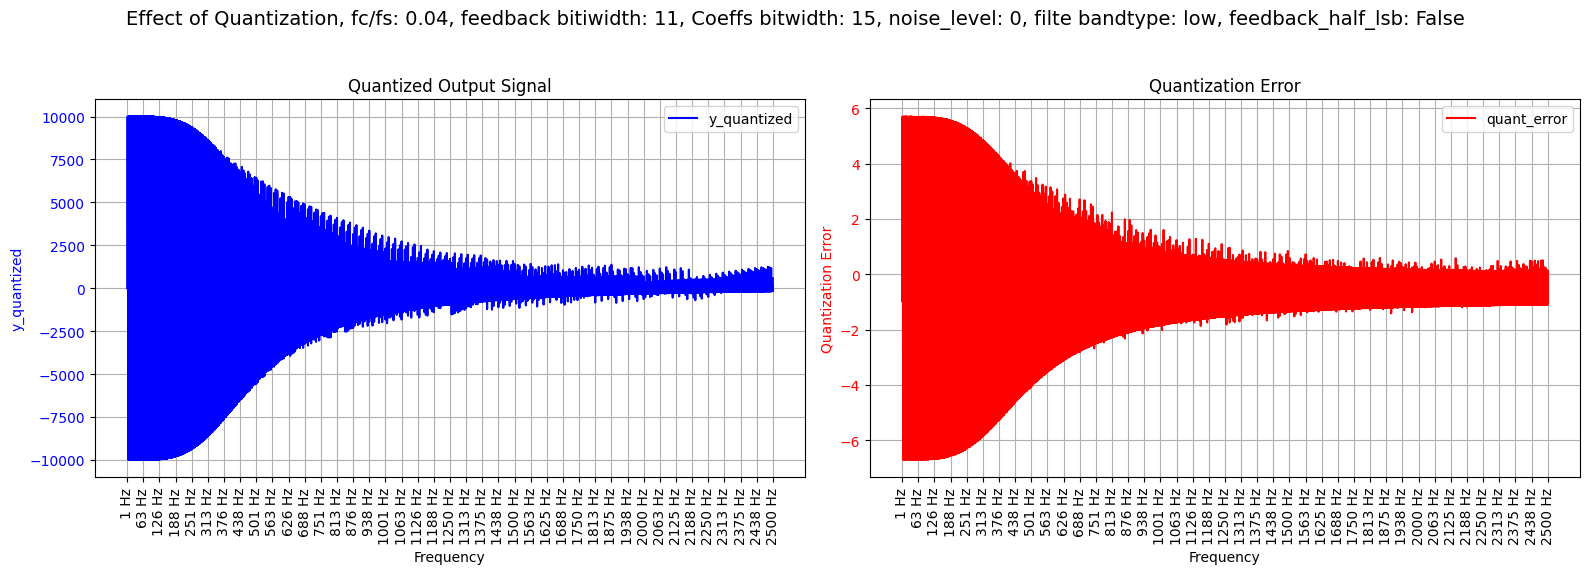

In [8]:
# test cases:
btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
fc_fs_ratio_lists =  [0.04] #[0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.2, 0.24] 
iir_coeff_bit_lists = [15] # [15, 16]
output_dec_bits_list = [11] #[11]
signal_range_list = [10000]
noise_level_list = [0] #[0, 1]
feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大

# signal generator params
# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 2500     # 终止频率
fs = 10000  # 每秒采样点数
time = 400  # 仿真时间

for btype in btype_lists:
    for signal_range in signal_range_list:
        generated_signal = signal_generator(fs, time, signal_range, start_freq, end_freq)
        for fc_fs_ratio in fc_fs_ratio_lists:
            for iir_coeff_bit in iir_coeff_bit_lists:
                for output_dec_bits in output_dec_bits_list:
                    for noise_level in noise_level_list:
                        for feedback_half_lsb in feedback_half_lsb_list:
                            # 调用分析函数
                            print(f"Analyzing with fc/fs: {fc_fs_ratio}, iir_coeff_bit: {iir_coeff_bit}, output_dec_bits: {output_dec_bits}, signal_range: {signal_range}, noise_level: {noise_level}, filte bandtype: {btype}, feedback_half_lsb: {feedback_half_lsb}")
                            analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=fs, signal_range=signal_range, noise_level=noise_level, btype=btype, feedback_half_lsb=feedback_half_lsb)